# Project 2: Ames Housing Predicition
__________________________________________________________________________________________________________________________

## Model Tuning and Conclusion

### Contents:
01_EDA_and_Cleaning.ipynb <br>
02_Preprocessing.ipynb<br>
**03_Feature_Engineering_and_Model_Benchmarks.ipynb** (Current Notebook)<br>
|   |__ a__ [Libraries](#Libraries)<br>
|   |__ b__ [Import Preprocessed Data](#Import-Preprocessed-Data)<br>
|   |__ d__ [Train-Test Split](#Train-test-Split-of-Data)<br>
|   |__ e__ [Scale Data](#Scale-Data)<br>
|   |__ f__ [Instantiate Model](#Instantiate-Model)<br>
|   |__ g__ [Modelling](#Modeling)<br> 
|   |__ h__ [Cross Validation](#Cross-Validation)<br>
|   |__ i__ [Model Evaluation](#Model-Evaluation)<br>
|   |__ j__ [Generate Prediction (Kaggle)](#Generate-Predictions-(Kaggle))<br>
|   |__ i__ [Submission of Results to Kaggle](#Submission-of-Results-to-Kaggle)<br>
|   |__ k__ [Conclusion and Recommendation](#Conclusion-and-Recommendation)<br>

### Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore') 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

%matplotlib inline

#editting of setting to view all columns and rows within the dataset
pd.options.display.max_columns = None 
#There are 80+ columns withing the dataframe, this setting is required if you want to view the entire columns in the dataframe.
pd.options.display.max_rows = None

## Import Preprocessed Data

In [2]:
train = pd.read_csv("../datasets/train_clean.csv")
test = pd.read_csv("../datasets/test_clean.csv")

In [3]:
train.shape, test.shape

((2049, 224), (879, 223))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Columns: 224 entries, id to yrsold_2010
dtypes: float64(16), int64(208)
memory usage: 3.5 MB


In [5]:
train.head()

,id,pid,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremod/add,masvnrarea,exterqual,extercond,bsmtqual,bsmtcond,bsmtexposure,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heatingqc,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,fireplaces,fireplacequ,garageyrblt,garagearea,garagequal,garagecond,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,miscval,saleprice,garagecars,totalbath,bsmttotalbath,bltage,lastremod,mssubclass_160,mssubclass_180,mssubclass_190,mssubclass_20,mssubclass_30,mssubclass_40,mssubclass_45,mssubclass_50,mssubclass_60,mssubclass_70,mssubclass_75,mssubclass_80,mssubclass_85,mssubclass_90,mszoning_FV,mszoning_I (all),mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_HLS,landcontour_Low,landcontour_Lvl,utilities_NoSewr,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Mod,landslope_Sev,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Feedr,condition1_Norm,condition1_PosA,condition1_PosN,condition1_RRAe,condition1_RRAn,condition1_RRNe,condition1_RRNn,condition2_Norm,condition2_PosA,condition2_PosN,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Gable,roofstyle_Gambrel,roofstyle_Hip,roofstyle_Mansard,roofstyle_Shed,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CemntBd,exterior1st_HdBoard,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsphShn,exterior2nd_Brk Cmn,exterior2nd_BrkFace,exterior2nd_CBlock,exterior2nd_CmentBd,exterior2nd_HdBoard,exterior2nd_ImStucc,exterior2nd_MetalSd,exterior2nd_Plywood,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkFace,masvnrtype_None,masvnrtype_Stone,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,paveddrive_P,paveddrive_Y,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_None,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_None,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_GasW,heating_Grav,electrical_FuseF,electrical_FuseP,electrical_SBrkr,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagetype_None,garagefinish_None,garagefinish_RFn,garagefinish_Unf,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,mosold_2,mosold_3,mosold_4,mosold_5,mosold_6,mosold_7,mosold_8,mosold_9,mosold_10,mosold_11,mosold_12,yrsold_2007,yrsold_2008,yrsold_2009,yrsold_2010
0,109,533352170,0.0,13517,6,8,1976,2005,289.0,2.5,0.0,3,3,0,533.0,0.0,192.0,725.0,5.0,725,754,0,1479,3,1,2.5,6,0,0.0,1976.0,475.0,3,3,0,44,0,0,0,0,0,0,130500,0.0,2.5,0.0,44,15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,544,531379050,43.0,11492,7,5,1996,1997,132.0,2.5,0.0,4,3

## Train-test Split of Data

In [6]:
#features = [col for col in train.columns if col != ["saleprice", "id"]]
X = train.drop(columns = ["id", "saleprice"])
y = train["saleprice"]

In [7]:
X.shape, y.shape

((2049, 222), (2049,))

In [8]:
#Removes the 100 features least correlated with sale price.
#Specifically, this code makes a sorted list of the magnitude of all feature correlations with sale price,
#drops the 100 smallest correlations, grabs remaining feature names, and condenses feature set to only those features.
features_keep = list(abs(X.corrwith(y)).sort_values(ascending=False)[:-80].index)
X = X[features_keep]

In [9]:
X.shape, y.shape

((2049, 142), (2049,))

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [11]:
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (1434, 142)
Shape of X_test: (615, 142)
Shape of y_train: (1434,)
Shape of y_test: (615,)


## Scale Data

In [12]:
ss = StandardScaler()

In [13]:
# Fit and transform.
X_train_scaled =  ss.fit_transform(X_train)

# Transform.
X_test_scaled = ss.transform(X_test)

## Instantiate Model

#### Linear Regression

In [14]:
#setting LinearRegression as lr
lr = LinearRegression()

#### Ridge

In [15]:
#setting alpha using logspace
r_alpha = np.logspace (0,5,200)

#setting RidgeCV as ridge
ridge = RidgeCV(alphas = r_alpha) 

#### Lasso

In [16]:
#setting LassoCV as lasso with n_alphas as 100
lasso = LassoCV(n_alphas = 100)

#### Elastic Net

In [25]:
enet_alpha = np.arange(0, 1, 0.05)
enet_ratio = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

# fits multiple alphas and rhos
enet = ElasticNetCV(alphas = enet_alpha, l1_ratio = enet_ratio, cv = 5)
enet = enet.fit(X_train_scaled, y_train)

## Cross Validation

In [17]:
#LR Estimate of test R2 using cross validation
lr_cv_score = cross_val_score(lr, X_train_scaled, y_train, cv = 5)
lr_cv_score.mean()

0.8190746455052189

In [18]:
#LR Estimate of test MSE using cross validation
lr_cv_mse_score = -cross_val_score(lr, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_squared_error")
lr_cv_mse_score.mean()

1043903187.5769205

In [19]:
#Ridge Estimate of test R2 on cross validation
#Ridge is better than lr in terms of R2
ridge_cv_score = cross_val_score(ridge, X_train_scaled, y_train, cv = 5)
ridge_cv_score.mean()

0.8363132652788051

In [20]:
#Ridge Estimate of test MSE using cross validation
ridge_cv_mse_score = -cross_val_score(ridge, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv_mse_score.mean()

952535754.8095639

In [21]:
#Lasso Estimate of test R2 on cross validation
#R2 no degree of freedom as we use more features the R2 will just get better and better
#It will be better to validate using MSE (MSE smaller better)
lasso_cv_score = cross_val_score(lasso, X_train_scaled, y_train, cv = 5)
lasso_cv_score.mean()

0.8323436403201715

In [22]:
#Lasso Estimate of test MSE using cross validation
lasso_cv_mse_score = -cross_val_score(lasso, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_squared_error")
lasso_cv_mse_score.mean()

972267528.8979776

In [26]:
enet_cv_score = cross_val_score(enet, X_train_scaled, y_train, cv = 5)
enet_cv_score.mean()

0.8392594969137214

In [27]:
enet_cv_mse_score = -cross_val_score(enet, X_train_scaled, y_train, cv = 5, scoring = "neg_mean_squared_error")
enet_cv_mse_score.mean()

938111999.4702116

## Model Fitting and Evaluation
---

Three models were tested: (1) Linear Regression, (2) Ridge Regression and (3) Lasso Regression. <br>
Overall, for the test model, Lasso scored better against Linear Regression and Ridge as reflected in the R2 and RMSE score.

In [28]:
lr.fit(X_train_scaled, y_train)
print("Training R2(LR): " + str(lr.score(X_train_scaled, y_train)))
print("Test R2(LR): " + str(lr.score(X_test_scaled, y_test)))
print("Estimate of Testing R2(LR): " +str(lr_cv_score.mean()))
#test is lower than training indicates overfitting but the value is minor as the score is little
#estimate testing is the main R2 score

Training R2(LR): 0.9000846226530772
Test R2(LR): -4.301026135523079e+18
Estimate of Testing R2(LR): 0.8190746455052189


In [29]:
print("Training MSE(LR): " + str(mean_squared_error(y_train, lr.predict(X_train_scaled))))
print("Test MSE(LR): " + str(mean_squared_error(y_test, lr.predict(X_test_scaled))))
print("Estimate of Testing MSE(LR): " +str(np.sqrt(lr_cv_mse_score.mean())))
#test MSE is bigger compared to training MSE

Training MSE(LR): 609089578.046124
Test MSE(LR): 2.880333982200418e+28
Estimate of Testing MSE(LR): 32309.490673437125


In [30]:
ridge.fit(X_train_scaled, y_train)
print("Training R2(Ridge): " + str(ridge.score(X_train_scaled, y_train)))
print("Test R2(Ridge): " + str(ridge.score(X_test_scaled, y_test)))
print("Estimate of Testing R2(Ridge): " +str(ridge_cv_score.mean()))

Training R2(Ridge): 0.8883085204798984
Test R2(Ridge): 0.8951834320264928
Estimate of Testing R2(Ridge): 0.8363132652788051


In [31]:
print("Training MSE(Ridge): " + str(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print("Test MSE(Ridge): " + str(mean_squared_error(y_test, ridge.predict(X_test_scaled))))
print("Estimate of Testing MSE(Ridge): " +str(np.sqrt(ridge_cv_mse_score.mean())))

Training MSE(Ridge): 680877337.789899
Test MSE(Ridge): 701941148.7370465
Estimate of Testing MSE(Ridge): 30863.17797650728


In [32]:
lasso.fit(X_train_scaled, y_train)
print("Training R2(Lasso): " + str(lasso.score(X_train_scaled, y_train)))
print("Test R2(Lasso): " + str(lasso.score(X_test_scaled, y_test)))
print("Estimate of Testing R2(Lasso): " +str(lasso_cv_score.mean()))

Training R2(Lasso): 0.8926784318912699
Test R2(Lasso): 0.9004498295586518
Estimate of Testing R2(Lasso): 0.8323436403201715


In [33]:
print("Training MSE(Lasso): " + str(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print("Test MSE(Lasso): " + str(mean_squared_error(y_test, lasso.predict(X_test_scaled))))
print("Estimate of Testing MSE(Lasso): " +str(np.sqrt(lasso_cv_mse_score.mean())))

Training MSE(Lasso): 654238120.0005343
Test MSE(Lasso): 666672858.5716587
Estimate of Testing MSE(Lasso): 31181.20473775793


In [34]:
enet.fit(X_train_scaled, y_train)
print("Training R2(ENet): " + str(enet.score(X_train_scaled, y_train)))
print("Test R2(ENet): " + str(enet.score(X_test_scaled, y_test)))
print("Estimate of Testing R2(Lasso): " +str(enet_cv_score.mean()))

Training R2(ENet): 0.8862870375725994
Test R2(ENet): 0.8933831524203772
Estimate of Testing R2(Lasso): 0.8392594969137214


In [35]:
print("Training MSE(ENet): " + str(mean_squared_error(y_train, enet.predict(X_train_scaled))))
print("Test MSE(ENet): " + str(mean_squared_error(y_test, enet.predict(X_test_scaled))))
print("Estimate of Testing MSE(ENet): " +str(np.sqrt(enet_cv_mse_score.mean())))

Training MSE(ENet): 693200407.6088618
Test MSE(ENet): 713997356.6362021
Estimate of Testing MSE(ENet): 30628.614063816396


## Model Evaluation

Lasso Regression was chosen as it has the highest R2 and is just slightly lower in terms of RMSE between the Elastic Net Regression and better than Linear Regression and Ridge Regression. 

In [36]:
#Using lasso, the remaining features was reduced to 84 for the prediction.
np.sum(lasso.coef_ != 0), np.sum(lasso.coef_ == 0)

(84, 58)

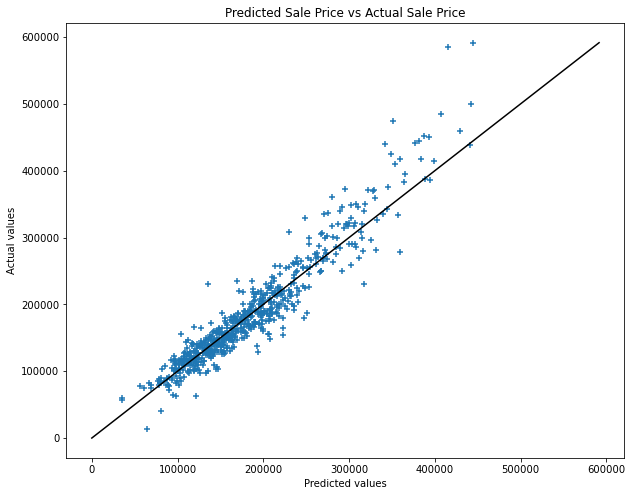

In [37]:
lasso_pred = lasso.predict(X_test_scaled)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(lasso_pred, y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted Sale Price vs Actual Sale Price')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

plt.savefig('../images/preds_vs_act_price.png')

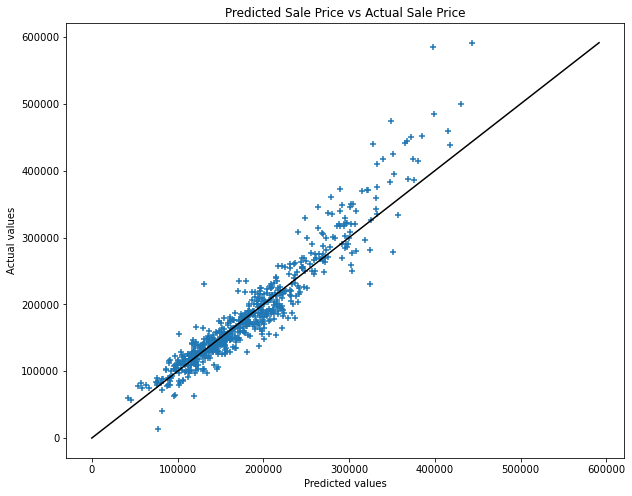

In [43]:
enet_pred = enet.predict(X_test_scaled)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(enet_pred, y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted Sale Price vs Actual Sale Price')

#Plots x=y line
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

plt.savefig('../images/enet_preds_vs_act_price.png')

## Generate Predictions (Kaggle)

In [38]:
# tranforming based on the most correlated features
test_scaled = ss.transform(test[features_keep])

In [39]:
# predict on test data
ypred = lasso.predict(test_scaled)

## Submission of Results to Kaggle

In [40]:
#creating a new dataframe based on Kaggle challenge submission format
submission = pd.DataFrame({
        'id': test['id'],
        'SalePrice': ypred
    },
    columns = ['id', 'SalePrice'])

In [41]:
#confirming the shape for prediction
submission.shape

(879, 2)

In [42]:
submission.to_csv('../datasets/kaggle_submission.csv',index=False)

## Conclusion and Recommendation

Between the three regression model, Lasso performs in terms of predicting the Ames housing price. Of note, Elastic Net Regression Model have yet to be tested but it should perform better than Lasso.

Among all the features within the dataset, features with condition, area or age gives a better predictor as compared to other features. With the predictor, the relationship between additional amenities (e.g. basement/garage) and the price becomes very prominent. The age of the building on the other hand shows that as the building ages, the price gradually decreases.

For existing homeowners looking to increase the value of their house, they can consider (1) Improving the quality of condition of basic amenities(e.g. house condition, kitchen) or (2) adding additional amenities within the house (e.g. garage, fireplace, pool).

However, people using the model to purchase the house should note that the model is based on dataset from 2006 - 2010 and the model may not hold as there may be changes in the past ten year (current year 2020). There may be other factors like government and external influence (e.g. pandemic or disasters) were not taken into consideration. Apart from that, this dataset is only done based on Ames, USA. Hence, it may not be applicable overseas let alone other states of US. Other factors like FOMO (Fear of Missing Out) will also cost a shift in saleprice and it is hard to predict at times.

In order to overcome the limitation, more data is required considering longer timeframe or other states or countries. More specialised consideration can be included like government's or external influence which may explain potential outliers within the data set.
